# 21 - Meta Learners
 
우리는 `treatment effect heterogeneity`(`TEH`, 처치 효과 이질성)를 찾고 싶습니다. `heterogeneity`(이질성)는 처치가 개별 `unit`에 미치는 영향이 다른 정도를 의미합니다. 즉, `unit`별로 처치 효과가 얼마나 다른지 알고 싶습니다. 수학적으로는 아래와 같습니다.
 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
$\tau(x)$는 `TEH`를 처치가 연속이라면 $E[\delta Y_i(t)|X]$와 같습니다. 다시 말해 우리는 `unit`이 처치에 얼마나 민감한지 구하고자 합니다. 예를 들어 적은 예산으로 모든 사람을 치료할 수 없다면 $\tau(x)$는 우선순위를 정하는 데 도움을 줄 수 있습니다 

20장에서는 `outcome` $Y$를 기계학습 예측 모델 넣어 `Conditional Average Treatment Effect`(`CATE`, 조건부 평균 처치 효과)를 추정하는 방법을 공부했습니다. 하지만 이 방법은 데이터의 잡음을 학습하는 문제가 있었습니다. 이는 기계학습 훈련에 자주 나타나는 과적합 문제입니다. 과적합을 처리하는 방법은 여러 가지 제안되었으며 각 방법은 장단점이 있습니다. 우리는 데이터에 따라 최적 방법을 선택할 수 있도록 다양한 것을 배워야 합니다. 21장에서는 다양한 도구를 사용할 수 있도록 하는 데 초점을 맞추었습니다.

<figure>
    <img src="data/img/meta-learners/learned-new-move.png">
    <figcaption>신난다! 데이터 과학자는 인과 추론을 얻었다.</figcaption>
</figure>

`Meta learner`는 `CATE`를 추정하기 위해 기계학습 모델을 활용하는 간단한 방법입니다. 다시 말하지만 가장 좋은 알고리즘은 없으며 각자 장단점이 있습니다. 알고리즘 선택은 문제에 따라 달라진다는 사실을 명심하세요. 또한, `Meta learner`에는 `linear regression`(선형 회귀), `decision tree`(결정 트리), `neural network`(신경망), `gaussian process`(가우스 과정) 등 다양한 기계학습 모델을 사용할 수 있습니다. `Meta learner` 성공 여부는 어떤 모델을 도입하느냐에 따라 크게 달라집니다. 여러분은 많은 것을 시도해보고 가장 좋은 것을 선택해야 합니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

앞에서 사용했던 투자 광고 이메일 데이터를 사용해 봅시다. 목표는 이메일에 잘 반응하는 사람을 찾는 것입니다. 이번에는 문제를 약간 바꿔 비무작위 데이터로 모델을 학습하고 무작위 데이터를 검증해보겠습니다. 데이터의 편향을 제거하고 `CATE`를 추정해야 하므로 비무작위 데이터를 다루기는 훨씬 어려운 작업입니다.

In [2]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

age   income  insurance  invested  em1  em2  em3  converted
0  44.1  5483.80    6155.29  14294.81    0    0    1          0
1  39.8  2737.92   50069.40   7468.15    1    0    0          0
2  49.0  2712.51    5707.08   5095.65    0    0    1          1
3  39.7  2326.37   15657.97   6345.20    0    0    0          0
4  35.3  2787.26   27074.44  14114.86    1    1    0          0

`outcome`은 `converted`, `treatment`는 `em1`입니다. `TEH`를 찾기 위해 아래와 같이 변수를 지정합니다.

In [3]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-Learner

`S-learner`는 가장 단순한 방법입니다. `S-Learner`는 `single`(단일) 모델 $M_s$로 구성됩니다. `S-learner`의 이름은 `single model`에서 따왔습니다.

$
\mu(x) = E[Y| T, X]
$

`treatment` $T$는 모델의 `feature`와 함께 입력값으로 사용되며 모델은 `outcome` $Y$를 반환합니다.

In [4]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

`treatment` 조건에 따라 `outcome`을 계산할 수 있는데, 실험군($T=1$)과 대조군($T=0$) 예측값 차이는 `CATE`가 됩니다.

$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$
 
아래는 `S-lerner`를 요약한 그림입니다.

![img](data/img/meta-learners/s-learner.png)
 
그럼 `S-learner`를 구현해 보겠습니다.

In [5]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) - 
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0})))  # predict under control
)

모델 평가를 위해 테스트 데이터에 대한 누적 이득 곡선을 그려보겠습니다. 그래프에는 훈련 데이터 결과가 함께 표기되었습니다. 훈련 데이터는 편향되어 있어 누적 이득 곡선으로 정확히 평가할 수는 없지만 과적합 여부를 확인할 수 있습니다. 과적합일 때 훈련 데이터의 곡선 수준은 매우 높게 나타납니다. 더 과적합 된 경우를 확인하고 싶다면 모델 파라미터 `max_depth`를 $3$에서 $20$으로 바꿔보세요.

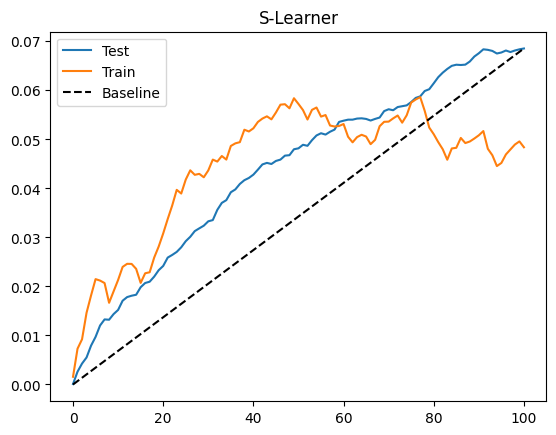

In [6]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

<figure>
    <img src="data/img/meta-learners/not-great-not-terrible.jpeg">
    <figcaption>좋지도 나쁘지도 않네</figcaption>
</figure>

누적 이득 곡선에서 보이듯이 `S-learner`는 단순하지만 잘 작동합니다. 한 가지 명심해야 할 점은 **이 데이터**에 잘 맞는다는 점입니다. 데이터에 따라 모델의 성능은 더 좋을 수도, 더 나쁠 수 있습니다. 단순한 `S-learner` 특성상 인과추론에 가장 먼저 시도해볼 만 합니다. `S-learner`는 범주형, 연속형 처치 모두 적용할 수 있는 장점이 있습니다. 반면 앞으로 살펴볼 `Meta learner`는 범주형 처치에만 적용할 수 있습니다.

`S-learner`의 단점은 처치 효과를 $0$으로 편향시키는 것입니다. `S-learner`는 일반적으로 정규화된 기계학습 모델을 사용하므로 추정된 처치 효과를 제한합니다. [Chernozhukov et al (2016)](https://arxiv.org/abs/1608.00060)에서 시뮬레이션 데이터를 활용해 이 문제를 다루기도 했습니다.

<figure>
    <img src="data/img/meta-learners/zero-bias-s-learner.png">
    <figcaption>Zero bias of the S-learner</figcaption>
</figure>
 
위 그림은 실제 인과 효과(빨간색)와 `S-learner`로 추정한 인과 효과($\hat{\tau}$)에서 실제 인과효과를 뺀 값($\tau-\hat{\tau}$)의 히스토그램입니다. 추정된 인과 효과는 대부분 실제 인과효과 보다 작게 평가하는 편향('downward biased')을 갖습니다. ($\tau-\hat{\tau}>0$) 즉 실제 인과 효과는 추정값보다 큰 경향이 있습니다.  

또한, $Y$에 대한 $T$의 기여도가 $X$에 비해 매우 작다면 `S-learner`는 처치 효과를 무시할 가능성이 있습니다. 이러한 경향은 사용한 모델에 따라 매우 다르며 정규화 정도가 클수록 문제 되기 쉽습니다. 이제 이 문제를 해결하는 방법인 `T-learner`를 살펴보겠습니다.

## T-Learner
 
`T-learner`는 처치에 따라 데이터를 강제로 분리해 문제를 해결하려 합니다. 단일 모델 대신 처치에 따라 개별 모델을 사용합니다. 이산 처치면 `T-learner`는 2개 모델을 훈련합니다. `T`는 2(two)를 의미합니다.

$
\mu_0(x) = E[Y| T=0, X]
$
 
$
\mu_1(x) = E[Y| T=1, X]
$
 
`counterfactual`(반사실) 예측과의 차이로 `CATE`를 추정합니다.
 
$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$
 
이를 도표로 나타내면 다음과 같습니다.

<figure>
    <img src="data/img/meta-learners/t-learner.png">
    <figcaption>T-learner</figcaption>
</figure>

이론은 충분합니다. `T-learner`를 코드로 구현해보겠습니다.

In [7]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

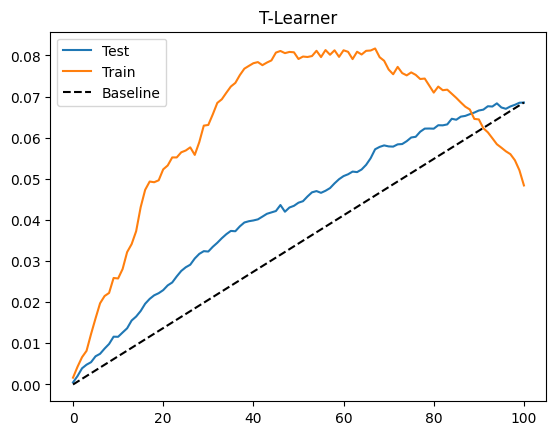

In [8]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("T-Learner");

`T-learner` 또한 **지금 데이터**에 잘 작동합니다. 테스트 성능은 `S-learner`와 큰 차이가 없어 보입니다. 이는 처치가 너무 약하지 않기 때문일 수 있습니다. 또한, 훈련 성능이 테스트 성능보다 훨씬 높은걸 볼 수 있는데 이는 모델이 과적합 되었음을 보여줍니다. 과적합은 모델이 더 작은 데이터를 훈련하는 것이 원인일 수 있습니다. 데이터 수가 적어지면 모델이 잡음을 학습하기 쉽기 때문입니다.

`T-learner`로 약한 처치 효과를 무시하는 현상은 피할 수 있지만, 여전히 정규화 편향 문제를 가집니다. [Kunzel et al, 2019](https://arxiv.org/abs/1706.03461)에서 발표된 상황을 살펴보겠습니다. 처치되지 않은 데이터보다 상대적으로 처치된 데이터는 적습니다. 처치된 데이터를 얻는 비용이 크기 때문에 실제로 자주 발생하는 문제입니다. $Y$는 비선형성을 갖지만 **처치 효과는 일정하다**고 가정해 보죠. 아래 그림으로 어떤 일이 일어나는지 확인해 봅시다.

![img](data/img/meta-learners/t-learner-problem.png)
 
처치된 데이터 수가 부족하므로 과적합을 피하고자 $M_1$은 매우 단순한 모델(이 경우 선형)을 사용합니다. $M_0$은 데이터가 많아 과적합 문제가 덜 하므로 상대적으로 복잡한 모델을 사용합니다. 이는 기계학습 관점에서 꽤 합리적입니다. 하지만 `CATE`, $\hat{\tau}=M_1(X) - M_0(X)$를 계산하면 비선형 곡선을 얻게 되는데 이 지점에서 뭔가 잘못됬다는 것을 발견합니다. 왜냐하면, 우리의 outcome인 converted는 계약하거나(1), 하지 않는 것(0)이므로 `CATE`는 모든 경우에서 값이 $1$인 상수이기 때문입니다.[위의 그림에서 $M_1(X)$은 선형(파란색 선), $M_0(X)$는 비선형(빨간색 선)이므로 차이 또한 비선형입니다.] 
 
문제는 처치되지 않은 data를 예측하는 모델에서 비선형성을 잡아내지만, 처치된 모델에서는 비선형성을 잡아내지 못한다는 것에 있습니다. 작은 데이터를 학습하기 위해 정규화가 큰 모델을 사용하기 때문입니다. 물론 정규화 정도가 작은 모델을 사용할 수 있지만 과적합 문제가 발생합니다. 진퇴양난의 곤경에 처한 것 같네요. 이 문제는 [Kunzel et al, 2019](https://arxiv.org/abs/1706.03461)에서 제안된 `X-learner`로 해결할 수 있습니다.

## X-Learner
 
`X-learner`는 `S-learner`나 `T-learner`에 비해 상당히 복잡합니다. 하지만 구현은 간단하니 걱정하지 마세요. `X-learner`는 두 단계 (`first stage`와 `second stage`)로 이루어져 있으며 성향 점수를 활용합니다. 첫 번째 단계는 `T-learner`와 같습니다. 먼저 처치된 데이터와 처치되지 않은 데이터로 2개 모델을 훈련합니다.

$
\hat{M}_0(X) \approx E[Y| T=0, X]
$
 
$
\hat{M}_1(X) \approx E[Y| T=1, X]
$
 
두 번째 단계에서는 처치된 데이터, 처치되지 않은 데이터로 두 개 모델을 활용해 처치 효과를 얻습니다.

$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$
 
$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$
 
그리고 처치 효과를 추정하는 두 개 모델을 추가로 훈련합니다.
 
$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$
 
$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$
 
위 수식의 의미를 파악하기 위해 아래에 있는 그림(b)를 보겠습니다. $\hat{\tau}(X, T=0)$는 '(모델$\hat{M}_1$으로 계산한) 처지된 데이터가 만약 처치를 받지 않았다면 가졌을 y의 추정값'에서 $Y_{t=0}$을 빼서 얻은 '통제군의 처치효과'이며, 그림(b)에서 '빨간색 x 모양'의 표식에 해당합니다(위에서 본 그림(a)와 비교하면 파란선에서 빨간선을 뺀 값 임). 또한, $\hat{M}_{\tau 0}(X)$는 그림에서 빨간색 점선입니다. 이 모델은 틀렸다는 사실에 유의하세요. $\hat{\tau}(X, T=0)$는 적은 수의 처치된 데이터로 학습된 모델 $\hat{M}_1$에 의해 계산된 것이기 때문입니다. 모델은 $Y$의 비선형성을 잡아내지 못하므로 처치 효과 또한 비선형으로 나타납니다.

파란색 점은 처치된 데이터에 대한 처치 효과 $\hat{\tau}(X, T=1)$입니다. 이는 많은 수의 처치 되지 않은 데이터로 훈련한 모델 $M_0$으로 추정한 올바른 값입니다. 파란색 선으로 표시된 처치 효과는 적절한 값으로 `second stage` 모델인 $\hat{M}_{\tau 1}(X)$를 훈련할 수 있습니다.
 
![img](data/img/meta-learners/second-stage-x.png)
 
이제 두 개 모델을 얻었습니다. $\hat{M}_{\tau 0}(X)$은 잘못된 처치 효과를 예측하는 틀린 모델이고, $\hat{M}_{\tau 1}(X)$은 옳은 처치 효과를 예측하는 맞는 모델입니다. 이제 올바른 모델에 더 높은 가중치를 주는 방식으로 결합하려 합니다. 여기서 성향 점수 $\hat{e}(x)$를 도입합니다. 아래와 같이 `second state`의 모델들을 결합합니다.

$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$
 
처치된 데이터는 수가 적으므로 $\hat{e}(x)$ 또한 작습니다. 이는 잘못된 모델인 $\hat{M}_{\tau 0}(X)$에 매우 작은 가중치를 할당합니다.  

반면 $1-\hat{e}(x)$은 1에 가까운 값입니다. 따라서 옳은 모델인 $\hat{M}_{\tau 1}(X)$에 높은 가중치가 할당됩니다. 일반적으로 성향 점수를 사용한 가중 평균은 처치 가능성이 높은 데이터에 `CATE` 모델 가중치를 높게 설정합니다. 즉, 더 많은 데이터로 훈련된 모델을 선호합니다. 아래 그림은 `X-learner`(검은색 점선)와 `T-learner`(검은색 실선)가 추정한 CATE를 나타냅니다.
 
![img](data/img/meta-learners/t-vs-x-learner.png)
 
`X-learner`는 `T-learner`보다 비선형으로 추정된 잘못된 `CATE`를 잘 수정합니다. 일반적으로 `X-learner`는 처치가 불균형할 때 효과가 좋습니다. 설명은 많았지만, 코드는 단순합니다. 아래 그림은 `X-lerner`의 요약입니다.

![img](data/img/meta-learners/x-learner.png)
 
다음으로는 코드입니다. 첫 번째 단계는 `T-learner`와 같습니다.

In [9]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

이제 처치 효과를 예측해 `second stage` 모델을 훈련합니다.

In [10]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0]);
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

마지막으로 성향 점수로 예측값을 보정합니다.

In [11]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,0)*mx0.predict(train[X]) +
                ps_predict(train,1)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,0)*mx0.predict(test[X]) +
                                ps_predict(test,1)*mx1.predict(test[X])))

`X-learner`를 평가해 보겠습니다. 누적 이득 곡선을 그려봅시다.

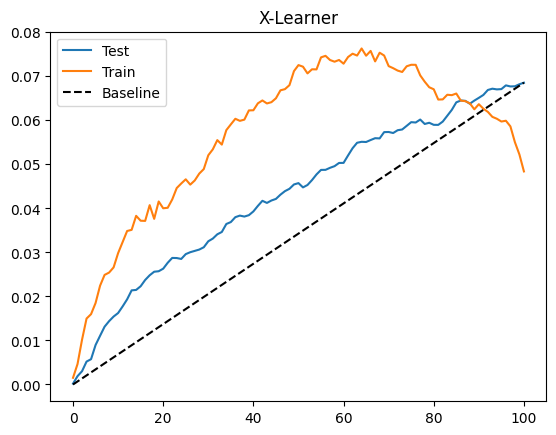

In [12]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("X-Learner");

또다시 **이 데이터**에 잘 작동하는 결과를 얻었습니다. `S`, `T`, `X-learner` 결과는 거의 비슷해 보입니다. 그래도 이 모든 `meta learner`를 배우는 것은 중요합니다. 이제 여러분은 데이터에 따라 적합한 모델을 선택해 사용할 수 있습니다. 결과는 기계학습 모델에 크게 의존한다는 사실을 기억하세요. 이 장에서는 기계학습 모델로 `LightGBM`을 사용했지만, 다른 모델을 사용하거나 혹은 `hyperparameter`를 변경함으로써 성능을 올릴 수 있습니다.

## Key Ideas
 
`S-learner`는 단순한 모델로 $T$를 모델의 `feature`로 사용합니다. `S-learner`는 $T$ 다른 $X$에 비해 기여도가 낮지 않을 때 잘 작동하는 경향이 있습니다. 반면 `S-learner`는 $0$으로 편향되거나 처치 효과가 작을 때 처치 자체가 무시되는 문제가 있습니다. `T-learner`는 조금 더 복잡한 모델로 약한 처치 효과를 다룰 수 있습니다. `T-learner`에서는 처치 여부에 따라 개별 모델을 사용합니다. 이 방법은 각 처치에 대해 충분히 많은 데이터가 있을 때 잘 작동하며 데이터 크기가 작아지면 실패할 수 있습니다. 이를 해결하기 위해 `X-learner`가 제안되었으며 이는 높은 수준의 복잡성을 추가합니다. `X-learner`는 두 단계로 구성되어 있으며 성향 점수로 작은 데이터에 대한 잠재적인 문제를 해결할 수 있습니다.  
 
`T`, `X-learner`의 문제 중 하나는 범주형 처치에만 적용할 수 있다는 점입니다. 연속형 처치는 더 일반적인 모델인 (아직 안 배웠어요) `R-learner`로 다룰 수 있습니다. `R-learner`에 대한 내용은 다음 장으로 이어집니다.

## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
To write this chapter, I've relied on Uber's *causalml* library and their documentation on meta learners. I've also took a lot of images and concept from Kunzela et al (2019), *Metalearners for estimating heterogeneous treatment effects using machine learning*. Finally, the discussion on the S-learner being biased towards zero was taken from Chernozhukov et al (2017), *Double/Debiased Machine Learning for Treatment and Causal Parameters*.
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).